# Tutorial 6: Using Connectivity Patterns

In [1]:
# Add the library to the path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sns_toolbox.design.connections import NonSpikingPatternConnection
from sns_toolbox.design.networks import Network
from sns_toolbox.design.neurons import NonSpikingNeuron

import sns_toolbox.simulate.backends as backends

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import sys

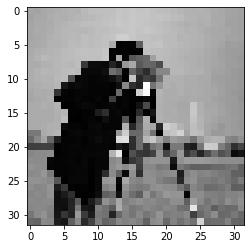

In [2]:
img = cv.imread('/home/will/Pictures/sample_images/cameraman.png')   # load image file

shape_original = img.shape  # dimensions of the original image
dim_long = max(shape_original[0],shape_original[1]) # longest dimension of the original image
dim_desired_max = 32    # constrain the longest dimension for easier processing
ratio = dim_desired_max/dim_long    # scaling ratio of original image
img_resized = cv.resize(img,None,fx=ratio,fy=ratio) # scale original image using ratio

img_color = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # transform the image from BGR to RGB
img_color_resized = cv.cvtColor(img_resized, cv.COLOR_BGR2RGB)  # resize the RGB image
img_gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)  # convert the resized image to grayscale [0-255]

shape = img_gray.shape  # dimensions of the resized grayscale image

img_flat = img_gray.flatten()   # flatten the image into 1 vector for neural processing
flat_size = len(img_flat)   # length of the flattened image vector

plt.imshow(img_gray,cmap='gray')

![title](kernel_diagram.png)

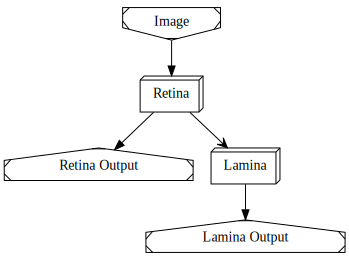

In [3]:
# General network
R = 20.0    # range of network activity (mV)
neuron_type = NonSpikingNeuron()    # generic neuron type
net = Network(name='Visual Network')    # create an empty network

# Retina
net.add_population(neuron_type,shape,name='Retina') # add a 2d population the same size as the scaled image
net.add_input('Retina', size=flat_size,name='Image')    # add a vector input for the flattened scaled image
net.add_output('Retina',name='Retina Output')  # add a vector output from the retina, scaled correctly

# Lamina
net.add_population(neuron_type,shape,name='Lamina')

del_e_ex = 160.0    # excitatory reversal potential
del_e_in = -80.0    # inhibitory reversal potential
k_ex = 1.0  # excitatory gain
k_in = -1.0/9.0 # inhibitory gain
g_max_ex = (k_ex*R)/(del_e_ex-k_ex*R)   # calculate excitatory conductance
g_max_in = (k_in*R)/(del_e_in-k_in*R)   # calculate inhibitory conductance

g_max_kernel = np.array([[g_max_in, g_max_in, g_max_in],    # kernel matrix of synaptic conductances
                         [g_max_in, g_max_ex, g_max_in],
                         [g_max_in, g_max_in, g_max_in]])
del_e_kernel = np.array([[del_e_in, del_e_in, del_e_in],    # kernel matrix of synaptic reversal potentials
                         [del_e_in, del_e_ex, del_e_in],
                         [del_e_in, del_e_in, del_e_in]])
connection_hpf = NonSpikingPatternConnection(g_max_kernel,del_e_kernel) # pattern connection (acts as high pass filter)
net.add_connection(connection_hpf,'Retina','Lamina',name='HPF') # connect the retina to the lamina
net.add_output('Lamina',name='Lamina Output')  # add a vector output from the lamina

img_flat = img_flat*R/255.0 # scale all the intensities from 0-255 to 0-R
net.graph

In [4]:
dt = neuron_type.params['membrane_capacitance']/neuron_type.params['membrane_conductance']  # calculate the ideal dt
t_max = 15  # run for 15 ms
steps = int(t_max/dt)   # number of steps to simulate

model = backends.SNS_Numpy(net,dt=dt,debug=False) # compile using the numpy backend

1 / 3 steps
2 / 3 steps
3 / 3 steps


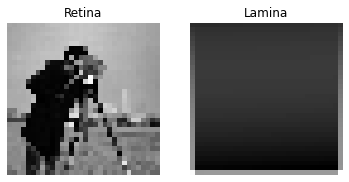

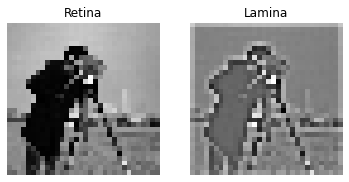

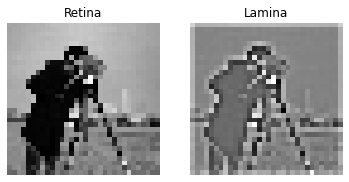

In [5]:
for i in range(steps):
    print('%i / %i steps'%(i+1,steps))
    plt.figure()    # create a figure for live plotting the retina and lamina states
    plt.subplot(1,2,1)
    plt.title('Retina')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Lamina')
    plt.axis('off')

    out = model.forward(img_flat)   # run the network for one dt
    retina = out[:flat_size]    # separate the retina and lamina states
    lamina = out[flat_size:]
    retina_reshape = np.reshape(retina,shape)   # reshape to from flat to an image
    lamina_reshape = np.reshape(lamina,shape)
    plt.subplot(1,2,1)  # plot the current state
    plt.imshow(retina_reshape,cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(lamina_reshape, cmap='gray')